<a href="https://colab.research.google.com/github/atenasadat/Sacasm-Detection/blob/main/ML_Project_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import re
import nltk
import gensim
import tokenize
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from gensim import models
from nltk.corpus import stopwords
from collections import Counter
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report


In [ ]:
# Loading data
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load Data

<div dir=rtl align=justify>


*   در این مرحله داده را لود می کنیم

</div>

In [ ]:
train_df = pd.read_csv("/content/gdrive/My Drive/ML/P2/DataSet/sarcasm_train_set.csv")
train_df

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
...,...,...,...,...,...,...,...,...,...,...,...
808993,1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
808994,1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
808995,1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
808996,1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [ ]:
test_df = pd.read_csv("/content/gdrive/My Drive/ML/P2/DataSet/sarcasm_test_set.csv")
test_df

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
1,11,0,Damn I was hoping God was real,Kvetch__22,baseball,14,-1,-1,2016-10,2016-10-28 09:07:50,James Shields Will Not Exercise Opt-Out Clause
2,27,0,This would make me cry.,neutralneutrals,AskReddit,1,-1,-1,2016-11,2016-11-07 12:03:16,"""You are like the end piece of bread in a loaf..."
3,28,0,At first I thought it was instructions on fixi...,Soperos,WTF,1,-1,-1,2016-10,2016-10-30 19:52:04,Found this under a box of porno mags well clea...
4,37,0,My stuffed animal I've had since I was born.,kn1820,AskReddit,1,-1,-1,2016-10,2016-10-11 11:17:42,Your house is burning down and you only have t...
...,...,...,...,...,...,...,...,...,...,...,...
201823,1010777,1,upvoted because I get sarcasm that doesn't nee...,thunder_rob,politics,1,1,0,2009-09,2009-09-24 13:20:29,He's history's greatest monster!
201824,1010784,1,"syndicate, shouldn't you be watching Fox News ...",chevymanusa,science,11,11,0,2009-10,2009-10-14 16:16:20,Haha. I love how you clearly Photoshopped the ...
201825,1010794,1,butbutbut racism ethnic discrimination cultura...,gnyffel,worldnews,107,107,0,2009-07,2009-07-23 19:52:55,Tell me again why we don't fucking vet people ...
201826,1010798,1,"Wow, that was quick.",SpudgeBoy,reddit.com,2,2,0,2009-08,2009-08-12 00:15:21,Eric Holder is expected to soon name a prosecu...


#EDA

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808998 entries, 0 to 808997
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      808998 non-null  int64 
 1   label           808998 non-null  int64 
 2   comment         808960 non-null  object
 3   author          808998 non-null  object
 4   subreddit       808998 non-null  object
 5   score           808998 non-null  int64 
 6   ups             808998 non-null  int64 
 7   downs           808998 non-null  int64 
 8   date            808998 non-null  object
 9   created_utc     808998 non-null  object
 10  parent_comment  808998 non-null  object
dtypes: int64(5), object(6)
memory usage: 67.9+ MB


In [ ]:
train_df['label'].value_counts()

1    404768
0    404230
Name: label, dtype: int64

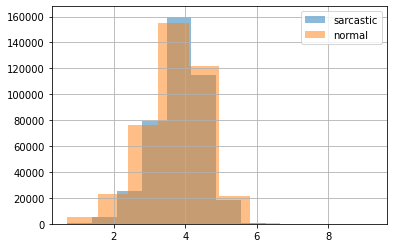

In [ ]:
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend();

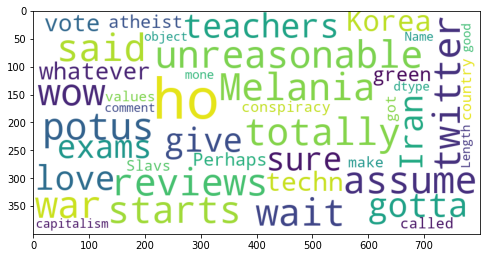

In [ ]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)


plt.figure(figsize=(8, 6))
wordcloud.generate(str(train_df.loc[train_df['label'] == 1, 'comment']))
plt.imshow(wordcloud);

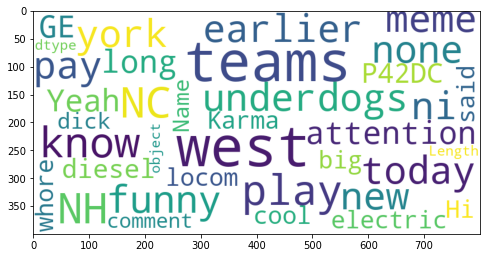

In [ ]:
plt.figure(figsize=(8, 6))
wordcloud.generate(str(train_df.loc[train_df['label'] == 0, 'comment']))
plt.imshow(wordcloud);

In [ ]:
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,52718,0.402310,21209
politics,31663,0.605533,19173
worldnews,21202,0.639940,13568
leagueoflegends,16835,0.546184,9195
pcmasterrace,15234,0.567612,8647
news,13504,0.600785,8113
funny,14292,0.453051,6475
pics,12952,0.486411,6300
todayilearned,11318,0.550892,6235


In [ ]:
sub_df[sub_df['size'] > 100].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,4381,0.787263,3449
circlebroke,141,0.730496,103
AndroidMasterRace,122,0.729508,89
ShitPoliticsSays,222,0.720721,160
progun,432,0.710648,307
wisconsin,171,0.707602,121
environment,291,0.697595,203
rage,694,0.697406,484
badwomensanatomy,135,0.688889,93


In [ ]:
sub_df = train_df.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
author,,,
NeonDisease,336,0.526786,177
pokemon_fetish,344,0.500000,172
Biffingston,668,0.497006,332
ShyBiDude89,304,0.486842,148


In [ ]:
sub_df = train_df[train_df['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
0,46439,0.614311,28528
26,1485,0.558923,830
20,2485,0.556539,1383
34,843,0.555160,468
18,3169,0.553487,1754
40,589,0.553480,326
16,4015,0.548941,2204
13,5821,0.546126,3179
39,645,0.544186,351


In [ ]:
sub_df = train_df[train_df['score'] < 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
-8,1473,0.701969,1034
-6,2470,0.694332,1715
-14,428,0.686916,294
-12,626,0.685304,429
-9,1211,0.684558,829
-10,940,0.680851,640
-3,5362,0.676800,3629
-7,1883,0.676049,1273
-4,4379,0.673898,2951


# PreProcessing data

In [ ]:
train_df['comment'].isnull().sum(), train_df['parent_comment'].isnull().sum(), test_df['comment'].isnull().sum(), test_df['parent_comment'].isnull().sum()

(38, 0, 15, 0)

In [ ]:
train_df = train_df.dropna(subset = ["comment"], inplace=False)
test_df = test_df.dropna(subset = ["comment"], inplace=False)

In [ ]:
train_df = train_df.drop(columns=['date'], inplace=False)
test_df = test_df.drop(columns=['date'], inplace=False)

In [ ]:
train_df = train_df.drop(columns=['created_utc'], inplace=False)
test_df = test_df.drop(columns=['created_utc'], inplace=False)

In [ ]:
# train_df = train_df.reset_index(drop=True)
# test_df = test_df.reset_index(drop=True)

from sklearn.metrics import classification_report

pred = []
test = [0]*101180 + [1]*100633
for i in range(201813):

  if i <  101180*0.73:
    pred.append(0)
  elif 101180 > i > 101180*0.73:
    pred.append(1)
  elif 101180 + 100633*0.29 > i > 101180*0.73:
    pred.append(0)
  elif i > 101180 + 100633*0.29:
    pred.append(1)

print(classification_report(test, pred))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72    101180
           1       0.72      0.71      0.72    100633

    accuracy                           0.72    201813
   macro avg       0.72      0.72      0.72    201813
weighted avg       0.72      0.72      0.72    201813



In [ ]:
def listToString(lst):
    string = []
    for x in lst:
        x = x.split(" ")
        st = ' '.join(map(str, x))
        string.append(st)
    return string


def prepare_text(text, remove_lst):

    tokens =word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]

    # Remove stopword
    # tokens = [word for word in tokens if not word in stopwords.words("english")]
    # Remove 30 most commen words
    tokens = [word for word in tokens if not word in remove_lst]

    # Lower the tokens
    tokens = [word.lower() for word in tokens]
    # Lemmatize
    lemma = nltk.WordNetLemmatizer()
    tokens = [lemma.lemmatize(word, pos = "v") for word in tokens]
    tokens = [lemma.lemmatize(word, pos = "n") for word in tokens]
    tokens = ' '.join(tokens)

    return tokens

def pre_proccess(lst, remove_lst):

    pre_lst =[]
    for title in lst:
        pre_lst.append(prepare_text(title, remove_lst))


    return pre_lst


def most_freq_words(df, column_name):

    listToStr = ' '.join(map(str, df[column_name]))
    listToStr = word_tokenize(listToStr)
    word_count = nltk.FreqDist(listToStr)
    s = word_count.most_common(30)
    return s




def PreProccess_for_classifier(df):

    print("Start preproccessing ...")
    train_d = {'comment': pre_proccess(listToString(df["comment"]), most_freq_words(df, 'comment')), 'parent_comment':pre_proccess(listToString(df["parent_comment"]), most_freq_words(df, 'parent_comment')), 'label':df["label"].copy()}
    print("Done preproccessing.")
    for i in range(len(train_d ['parent_comment'])):
        if len(train_d ['parent_comment'][i]) == 0:
            train_d ['parent_comment'][i] = "Parent Comment"
    return pd.DataFrame(train_d)

train_d = pd.read_csv("/content/gdrive/My Drive/ML/P2/DataSet/clean_train_data.csv")
test_d = pd.read_csv("/content/gdrive/My Drive/ML/P2/DataSet/clean_test_data.csv")

In [ ]:
train_d = train_d.fillna(" ")
train_d

,Unnamed: 0,comment,parent_comment,label
0,0,nc and nh,yeah i get that argument at this point i prefe...,0
1,1,you do know west team play against west team m...,the blazer and maverick the west and seed do n...,0
2,2,they be underdog earlier today but since gronk...,they favor to win,0
3,3,this meme be funny none of the new york nigga ...,deadass do kill my buzz,0
4,4,i do pay attention to her but a long a she leg...,do you find ariana grande sexy,0
...,...,...,...,...
808955,808955,i sure that iran and korea have the technology...,no one be call this an engineer pathogen but t...,1
808956,808956,whatever you do do vote green,in a move typical of their recent approach to ...,1
808957,808957,perhaps this be an atheist conspiracy to make ...,screw the disable i get to get to church on time,1
808958,808958,the slav get their own country it be call kosovo,i always be unsettle by that i hear a lot of j...,1


In [ ]:
test_d = test_d.fillna(" ")
test_d

,Unnamed: 0,comment,parent_comment,label
0,0,i could use one of those tool,yep can confirm i saw the tool they use for th...,0
1,1,damn i be hop god be real,jam shield will not exercise clause,0
2,2,this would make me cry,you be like the end piece of bread in a loaf e...,0
3,3,at first i think it be instruction on fix a ca...,find this under a box of porno mag well clean ...,0
4,4,my stuff animal i have since i be bear,your house be burn down and you only have time...,0
...,...,...,...,...
201808,201808,upvoted because i get sarcasm that do need the,he history greatest monster,1
201809,201809,syndicate should you be watch fox news right now,haha i love how you clearly photoshopped the p...,1
201810,201810,butbutbut racism ethnic discrimination cultura...,tell me again why we do fuck vet people at the...,1
201811,201811,wow that be quick,eric holder be expect to soon name a prosecuto...,1


# Implement TfIdf Embedding

## Train Data Embedding

In [ ]:
tvec = TfidfVectorizer(min_df=.0025, max_df=.1, stop_words='english', max_features=100)
tvec_weights = tvec.fit_transform(train_d['comment'].dropna())

comment_df = pd.DataFrame(tvec_weights.toarray(), columns=tvec.get_feature_names())
comment_df

,actually,bad,best,better,big,black,buy,ca,change,clearly,come,comment,day,end,feel,forget,fuck,game,god,good,great,guess,guy,happen,hear,help,job,just,kid,kill,know,leave,let,life,like,live,lol,long,look,lot,...,pretty,probably,problem,read,real,really,reddit,right,run,say,shit,sound,start,stop,sure,talk,team,tell,thank,thing,think,time,totally,trump,try,use,wait,want,watch,way,white,win,woman,work,world,wow,wrong,yeah,year,yes
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.226568,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.24235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.904979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.717137,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808955,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
808956,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
808957,0.0,0.652146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.568511,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
808958,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
p_tvec = TfidfVectorizer(min_df=.0025, max_df=.1, stop_words='english', max_features=100)
p_tvec_weights = p_tvec.fit_transform(train_d['parent_comment'].dropna())

parent_df = pd.DataFrame(p_tvec_weights.toarray(), columns=p_tvec.get_feature_names())
parent_df

KeyboardInterrupt: ignored

In [ ]:
for c in comment_df.columns:
  train_df[c + '_comment'] = comment_df[c]

for c in parent_df.columns:
  train_df[c + '_parent'] = parent_df[c]

train_df

In [ ]:
train_df.to_csv('train_df_processed.csv')
!cp train_df_processed.csv "/content/gdrive/My Drive/ML/P2/DataSet/train_df_processed.csv"

## Test Data Embedding

In [ ]:
tvec_test = TfidfVectorizer(min_df=.0025, max_df=.1, stop_words='english', max_features=100)
tvec_weights_test = tvec_test.fit_transform(test_d['comment'].dropna())

comment_df_test = pd.DataFrame(tvec_weights_test.toarray(), columns=tvec_test.get_feature_names())
comment_df_test

In [ ]:
p_tvec_test = TfidfVectorizer(min_df=.0025, max_df=.1, stop_words='english', max_features=100)
p_tvec_weights_test = p_tvec_test.fit_transform(test_d['parent_comment'].dropna())

parent_df_test = pd.DataFrame(p_tvec_weights_test.toarray(), columns=p_tvec_test.get_feature_names())
parent_df_test

In [ ]:
for c in comment_df_test.columns:
  test_df[c + '_comment'] = comment_df_test[c]

for c in parent_df_test.columns:
  test_df[c + '_parent'] = parent_df_test[c]

test_df

In [ ]:
test_df.to_csv('test_df_processed.csv')
!cp test_df_processed.csv "/content/gdrive/My Drive/ML/P2/DataSet/test_df_processed.csv"

# Implement Word2Vec Embedding

## Train Embedding

In [ ]:
## embeding comment column:
# comment_model = models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=10)
# comment_tagged = [models.doc2vec.TaggedDocument(words=list(r.split(" ")), tags=[str(i)]) for i, r in enumerate(train_d['comment'])]
# comment_model.build_vocab(comment_tagged)
# comment_model.train(comment_tagged, total_examples=comment_model.corpus_count, epochs=comment_model.epochs)

## embeding parent column:
# parent_model = models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=10)
# parent_tagged = [models.doc2vec.TaggedDocument(words=list(r.split(" ")), tags=[str(i)]) for i, r in enumerate(train_d['parent_comment'])]
# parent_model.build_vocab(parent_tagged)
# parent_model.train(parent_tagged, total_examples=parent_model.corpus_count, epochs=parent_model.epochs)

In [ ]:
# comment_model.save('doctovec_comment')
# parent_model.save('doctovec_parent')

# !cp doctovec_comment "/content/gdrive/My Drive/ML/P2/DataSet/"
# !cp doctovec_comment.docvecs.vectors_docs.npy "/content/gdrive/My Drive/ML/P2/DataSet/"
# !cp doctovec_parent.docvecs.vectors_docs.npy "/content/gdrive/My Drive/ML/P2/DataSet/"
# !cp doctovec_parent "/content/gdrive/My Drive/ML/P2/DataSet/"

comment_model = models.doc2vec.Doc2Vec.load('/content/gdrive/My Drive/ML/P2/DataSet/doctovec_comment')
parent_model = models.doc2vec.Doc2Vec.load('/content/gdrive/My Drive/ML/P2/DataSet/doctovec_parent')

In [ ]:
comment_embedding = pd.DataFrame([comment_model.infer_vector(list(r.split(" "))) for r in train_d['comment']])

parent_embedding = pd.DataFrame([parent_model.infer_vector(list(r.split(" "))) for r in train_d['parent_comment']])

In [ ]:
for c in comment_embedding.columns:
  train_df[str(c) + '_comment'] = comment_embedding[c]

for c in parent_embedding.columns:
  train_df[str(c) + '_parent'] = parent_embedding[c]

train_df

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,parent_comment,0_comment,1_comment,2_comment,3_comment,4_comment,5_comment,6_comment,7_comment,8_comment,9_comment,10_comment,11_comment,12_comment,13_comment,14_comment,15_comment,16_comment,17_comment,18_comment,19_comment,20_comment,21_comment,22_comment,23_comment,24_comment,25_comment,26_comment,27_comment,28_comment,29_comment,30_comment,...,60_parent,61_parent,62_parent,63_parent,64_parent,65_parent,66_parent,67_parent,68_parent,69_parent,70_parent,71_parent,72_parent,73_parent,74_parent,75_parent,76_parent,77_parent,78_parent,79_parent,80_parent,81_parent,82_parent,83_parent,84_parent,85_parent,86_parent,87_parent,88_parent,89_parent,90_parent,91_parent,92_parent,93_parent,94_parent,95_parent,96_parent,97_parent,98_parent,99_parent
0,0,0,NC and NH.,Trumpbart,politics,2,-1,-1,"Yeah, I get that argument. At this point, I'd ...",0.025809,0.028528,-0.016271,-0.005786,-0.060831,-0.033354,0.021538,0.049750,-0.030796,0.006848,0.009223,0.001848,0.031395,-0.023036,-0.020701,0.010475,-0.123759,0.022829,-0.044221,-0.012744,0.021843,-0.045865,-0.003169,0.029131,-0.044912,0.005323,-0.070233,0.054804,0.012607,0.051428,0.025150,...,-0.023638,-0.114207,-0.191535,-0.019737,0.020309,0.030681,-0.055369,-0.086719,0.118938,0.041684,-0.047391,0.139521,-0.037050,-0.094603,0.117855,-0.086097,0.114973,0.127868,0.048104,0.000536,-0.041412,0.054325,-0.088040,0.133394,-0.012436,0.248695,-0.123038,-0.093133,0.007159,0.076178,-0.053976,0.192733,-0.022527,-0.085273,-0.107922,-0.226380,0.129194,-0.058263,0.067629,0.092084
1,1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,The blazers and Mavericks (The wests 5 and 6 s...,-0.059254,0.221644,-0.231270,-0.007863,-0.262670,-0.011316,0.055412,0.199355,0.073863,-0.051269,0.080343,0.162486,0.049431,-0.055006,0.060867,0.006676,-0.113466,0.034841,0.017706,-0.114956,0.069516,-0.235362,-0.027501,-0.074187,0.019150,-0.011295,-0.198287,0.029899,-0.048523,0.054258,-0.031401,...,0.079566,-0.110901,-0.038187,0.000486,0.186620,-0.019583,0.056895,-0.166029,-0.080735,0.047144,-0.138165,0.022438,0.043272,-0.062111,-0.131237,0.134767,-0.021466,0.092842,-0.026987,0.037651,0.032805,0.005701,-0.055903,0.038494,0.016255,0.082129,-0.109491,-0.121199,0.052155,0.031364,-0.137529,0.112617,0.015941,-0.107772,-0.096129,0.084734,-0.019110,0.055455,-0.001426,-0.200503
2,2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,They're favored to win.,-0.019946,-0.087446,0.074266,-0.170806,-0.081813,0.112030,0.054866,0.010965,-0.126704,0.127678,0.025054,0.129847,-0.004053,-0.124669,0.143879,0.021952,-0.041601,-0.114783,-0.050214,-0.126228,0.116298,-0.086274,0.026443,-0.012564,0.043901,0.181084,-0.088507,0.058244,-0.136849,-0.062868,0.025824,...,0.013069,0.005813,-0.006499,-0.002832,0.136578,-0.088456,0.067240,-0.130691,0.087192,0.054811,-0.046471,0.058057,0.020469,-0.138234,-0.026996,0.021027,-0.003508,0.080555,-0.029252,0.045494,-0.037308,0.002744,-0.088056,-0.044889,0.051844,0.116096,-0.044816,-0.123783,0.044418,0.072291,-0.049829,0.075340,0.070749,-0.057463,-0.061865,0.012409,-0.012846,0.004732,0.037771,-0.122492
3,3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,deadass don't kill my buzz,0.151011,-0.018506,-0.038691,-0.018618,-0.012074,0.062127,-0.010896,0.006782,-0.060066,0.186998,-0.037270,0.042768,0.029859,0.055166,0.049166,0.045174,0.085872,-0.096781,-0.087713,-0.018701,0.017649,0.024412,-0.020186,-0.102556,-0.059729,0.037446,-0.034406,0.092087,0.047581,0.019919,0.004214,...,0.024161,-0.054012,-0.018261,-0.040905,0.049531,-0.048618,0.022652,-0.123255,0.013212,0.121302,0.020631,0.072368,0.062032,-0.093685,-0.052415,0.054309,-0.030081,0.051050,-0.050693,0.016097,-0.072947,-0.003955,-0.077654,-0.057239,-0.089860,0.093361,-0.000671,-0.147752,0.014930,0.067811,-0.069801,0.073357,0.079319,-0.041646,-0.054717,-0.015470,-0.028447,-0.034667,0.028514,-0.143489
4,5,0,"I don't pay attentio

## Test Embedding

In [ ]:
# # embeding comment column:
# comment_model_test = models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=10)
# comment_tagged_test = [models.doc2vec.TaggedDocument(words=list(r.split(" ")), tags=[str(i)]) for i, r in enumerate(test_d['comment'])]
# comment_model_test.build_vocab(comment_tagged_test)
# comment_model_test.train(comment_tagged_test, total_examples=comment_model_test.corpus_count, epochs=comment_model_test.epochs)

# # embeding parent column:
# parent_model_test = models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=10)
# parent_tagged_test = [models.doc2vec.TaggedDocument(words=list(r.split(" ")), tags=[str(i)]) for i, r in enumerate(test_d['parent_comment'])]
# parent_model_test.build_vocab(parent_tagged_test)
# parent_model_test.train(parent_tagged_test, total_examples=parent_model_test.corpus_count, epochs=parent_model_test.epochs)

In [ ]:
# comment_model_test.save('doctovec_comment_test')
# parent_model_test.save('doctovec_parent_test')

# !cp doctovec_comment_test "/content/gdrive/My Drive/ML/P2/DataSet/"
# !cp doctovec_comment_test.docvecs.vectors_docs.npy "/content/gdrive/My Drive/ML/P2/DataSet/"
# !cp doctovec_parent_test.docvecs.vectors_docs.npy "/content/gdrive/My Drive/ML/P2/DataSet/"
# !cp doctovec_parent_test "/content/gdrive/My Drive/ML/P2/DataSet/"

comment_model_test = models.doc2vec.Doc2Vec.load('/content/gdrive/My Drive/ML/P2/DataSet/doctovec_comment_test')
parent_model_test = models.doc2vec.Doc2Vec.load('/content/gdrive/My Drive/ML/P2/DataSet/doctovec_parent_test')

In [ ]:
comment_embedding_test = pd.DataFrame([comment_model_test.infer_vector(list(r.split(" "))) for r in test_d['comment']])

parent_embedding_test = pd.DataFrame([parent_model_test.infer_vector(list(r.split(" "))) for r in test_d['parent_comment']])

In [ ]:
for c in comment_embedding_test.columns:
  test_df[str(c) + '_comment'] = comment_embedding_test[c]

for c in parent_embedding_test.columns:
  test_df[str(c) + '_parent'] = parent_embedding_test[c]

test_df

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,parent_comment,0_comment,1_comment,2_comment,3_comment,4_comment,5_comment,6_comment,7_comment,8_comment,9_comment,10_comment,11_comment,12_comment,13_comment,14_comment,15_comment,16_comment,17_comment,18_comment,19_comment,20_comment,21_comment,22_comment,23_comment,24_comment,25_comment,26_comment,27_comment,28_comment,29_comment,30_comment,...,60_parent,61_parent,62_parent,63_parent,64_parent,65_parent,66_parent,67_parent,68_parent,69_parent,70_parent,71_parent,72_parent,73_parent,74_parent,75_parent,76_parent,77_parent,78_parent,79_parent,80_parent,81_parent,82_parent,83_parent,84_parent,85_parent,86_parent,87_parent,88_parent,89_parent,90_parent,91_parent,92_parent,93_parent,94_parent,95_parent,96_parent,97_parent,98_parent,99_parent
0,4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,Yep can confirm I saw the tool they use for th...,0.006164,0.012088,0.013345,0.021319,0.084719,-0.065455,0.016326,0.017245,-0.015985,0.010555,0.013611,-0.046852,0.027797,-0.000855,0.022050,0.061521,-0.049156,0.106757,0.054137,0.049383,-0.072212,-0.005263,-0.127501,0.032409,-0.011636,-0.028576,0.017652,0.002314,0.060072,0.013123,-0.039128,...,0.069747,0.045669,-0.109975,0.000782,0.089353,0.061037,0.013923,0.011071,0.048597,0.094091,0.037598,-0.003894,0.066594,0.052044,-0.109339,-0.017538,0.120177,0.080753,0.129106,-0.048812,0.018180,0.081841,0.096992,0.001086,0.033614,0.011854,-0.051632,-0.023091,-0.042526,-0.011662,-0.021098,-0.123287,-0.059613,-0.070318,-0.020590,0.053482,-0.066036,0.085941,0.124040,0.081933
1,11,0,Damn I was hoping God was real,Kvetch__22,baseball,14,-1,-1,James Shields Will Not Exercise Opt-Out Clause,0.051613,0.030707,-0.018511,-0.021189,0.064611,-0.115494,-0.042536,0.044947,-0.009398,0.010316,-0.050765,-0.041816,0.104278,0.000590,0.036151,0.053851,-0.083937,0.055797,0.050440,-0.032557,-0.085298,0.038905,-0.078617,0.006245,0.059668,-0.001103,-0.019107,-0.059888,0.036278,0.004189,0.000020,...,0.120632,-0.002703,-0.017396,0.085184,0.027301,-0.012973,-0.038764,-0.008900,0.030923,0.018565,-0.057705,-0.020895,-0.035529,0.051436,-0.126032,0.008995,0.067405,-0.038189,0.020392,-0.081193,0.074882,-0.047726,-0.043280,-0.073648,0.021497,0.016344,0.020942,-0.030796,0.080163,0.072892,0.014144,-0.110787,0.013254,0.070677,-0.001872,0.005658,0.074771,-0.017634,-0.084346,0.158051
2,27,0,This would make me cry.,neutralneutrals,AskReddit,1,-1,-1,"""You are like the end piece of bread in a loaf...",0.062556,0.086130,-0.052655,-0.010286,0.062364,-0.112035,-0.021714,0.003209,0.058455,0.026322,-0.091981,-0.043628,0.072444,0.053245,0.023650,0.086093,-0.105779,0.124506,0.099273,0.001440,-0.056047,-0.037311,-0.118742,-0.005539,-0.041429,-0.040502,-0.014862,0.069188,0.031275,-0.012527,0.002217,...,0.135886,0.012591,0.103719,0.077846,-0.116256,-0.077015,-0.031364,0.075449,0.026817,0.020295,-0.117273,0.023872,0.076535,-0.031885,0.076105,-0.021467,0.068753,0.070114,-0.051700,0.033020,0.091324,-0.113913,0.112995,-0.062742,-0.002566,-0.016881,0.014344,0.044892,0.159581,0.073547,-0.031873,-0.015028,-0.099495,0.080798,0.021063,0.063336,0.034385,-0.039137,0.017419,0.061422
3,28,0,At first I thought it was instructions on fixi...,Soperos,WTF,1,-1,-1,Found this under a box of porno mags well clea...,0.016144,-0.019022,0.025370,-0.025977,0.008826,0.032889,-0.070029,-0.062752,0.052406,0.043647,-0.031788,0.013096,-0.051835,-0.037954,-0.055704,-0.034718,-0.025720,-0.038065,-0.015626,-0.132863,0.017878,0.006120,0.036145,0.037849,0.004420,-0.004652,0.169377,-0.039170,-0.095880,0.076555,0.069752,...,0.136536,0.044237,-0.059838,0.049779,0.045116,-0.018683,0.104519,0.066907,0.100025,0.016592,0.093188,0.092598,0.052552,-0.009096,0.078730,-0.045000,0.010609,0.029193,-0.048167,0.029489,-0.027432,-0.084562,-0.026052,0.018544,-0.102596,-0.073430,-0.017706,-0.010404,0.000027,0.007309,-0.027615,-0.086291,-0.097649,-0.058552,0.063763,0.083340,0.028768,-0.002137,0.029577,-0.021523
4,37,0,My st

# Training

## Train with tf-idf embeding

In [ ]:
train_df = pd.read_csv("/content/gdrive/My Drive/ML/P2/DataSet/train_df_processed.csv")
test_df = pd.read_csv("/content/gdrive/My Drive/ML/P2/DataSet/test_df_processed.csv")
train_df = train_df.append(test_df.iloc[:1, :])

In [ ]:
from sklearn.model_selection import train_test_split

y = train_df['label'].values
X = train_df.iloc[:, 4:]
X = X.drop('parent_comment', axis=1).values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)
X

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression()
model.fit(X, y)
y_prob = model.predict_proba(X_valid)
y_prob = y_prob.ravel()[1::2]
y_pred = y_prob > 0.5
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.06      0.11     40536
           1       0.50      0.95      0.66     40360

    accuracy                           0.50     80896
   macro avg       0.53      0.51      0.38     80896
weighted avg       0.53      0.50      0.38     80896



**XGBoost**

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators=20000)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=True, early_stopping_rounds=100)

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import classification_report
y_prob = model.predict_proba(X_valid)
y_prob = y_prob.ravel()[1::2]
y_pred = y_prob > 0.5
print(classification_report(y_valid, y_pred))


              precision    recall  f1-score   support

           0       0.61      0.72      0.66     40536
           1       0.66      0.54      0.59     40360

    accuracy                           0.63     80896
   macro avg       0.63      0.63      0.63     80896
weighted avg       0.63      0.63      0.63     80896



In [ ]:
importance = pd.DataFrame()
importance['feature'] = train_df.drop('parent_comment', axis=1).columns[4:]
importance['importance'] = model.feature_importances_
importance = importance.sort_values("importance", ascending=False, ignore_index=True)
print("most important features")
print(importance.head(10))
print("least important features")
print(importance.tail(10))

most important features
             feature  importance
0  obviously_comment    0.076032
1       yeah_comment    0.070603
2    clearly_comment    0.051914
3    totally_comment    0.051637
4        wow_comment    0.029700
5     forget_comment    0.028660
6      woman_comment    0.027026
7      right_comment    0.021568
8      white_comment    0.020275
9              downs    0.020038
least important features
             feature  importance
194      want_parent    0.000964
195     video_parent    0.000961
196     maybe_parent    0.000950
197      run_comment    0.000940
198      life_parent    0.000865
199      buy_comment    0.000842
200  probably_parent    0.000840
201      idea_parent    0.000823
202     talk_comment    0.000756
203   change_comment    0.000000


**Neural Network**

In [ ]:
from keras.models import Sequential
from keras import layers, callbacks

callback = callbacks.EarlyStopping(monitor='loss', patience=20)
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X.shape[1],)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               52480     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 60,737
Trainable params: 60,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train,
          epochs=1000,
          validation_data=(X_valid, y_valid),
          callbacks=[callback],
          batch_size=1000)

Epoch 1/1000
729/729 [==============================] - 17s 4ms/step - loss: 11.3570 - accuracy: 0.5068 - val_loss: 4.4630 - val_accuracy: 0.5110
Epoch 2/1000
729/729 [==============================] - 2s 3ms/step - loss: 7.7780 - accuracy: 0.5148 - val_loss: 4.5508 - val_accuracy: 0.5140
Epoch 3/1000
729/729 [==============================] - 2s 3ms/step - loss: 5.9199 - accuracy: 0.5198 - val_loss: 3.9590 - val_accuracy: 0.5167
Epoch 4/1000
729/729 [==============================] - 2s 3ms/step - loss: 3.7661 - accuracy: 0.5284 - val_loss: 8.5243 - val_accuracy: 0.5115
Epoch 5/1000
729/729 [==============================] - 2s 3ms/step - loss: 2.6096 - accuracy: 0.5341 - val_loss: 0.8923 - val_accuracy: 0.5736
Epoch 6/1000
729/729 [==============================] - 3s 3ms/step - loss: 2.2647 - accuracy: 0.5397 - val_loss: 3.8001 - val_accuracy: 0.5167
Epoch 7/1000
729/729 [==============================] - 2s 3ms/step - loss: 1.2572 - accuracy: 0.5561 - val_loss: 0.8679 - val_accurac

In [ ]:
from sklearn.metrics import classification_report
y_prob = model.predict(X_valid)
# y_prob = y_prob.ravel()[1::2]
y_pred = y_prob > 0.5
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.67      0.63     40536
           1       0.62      0.56      0.59     40360

    accuracy                           0.61     80896
   macro avg       0.61      0.61      0.61     80896
weighted avg       0.61      0.61      0.61     80896



## Train with word2vec embeding

# Final Model

In [ ]:
params = [
          
  {
      "learning_rate" : 0.1,
      "gamma":0,
      "subsample":0.8,
  }
 ,
 
{
      "learning_rate":0.01,
      "gamma":0,
      "subsample":0.8,
 }
 ,
  {
      "learning_rate":0.01,
      "gamma":0,
      "subsample":0.5,
 }
 ]
import xgboost as xgb

for param in params:
  model = xgb.XGBClassifier(n_estimators= 20000,nthread=4 ,**param )
  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=True, early_stopping_rounds=100)




In [ ]:

y_prob = model.predict_proba(X_valid)
y_prob = y_prob.ravel()[1::2]
y_pred = y_prob > 0.5
print(classification_report(y_valid, y_pred))


# Test Model

In [ ]:
import xgboost as xgb

final_model = xgb.XGBClassifier(n_estimators= 20000,nthread=4 )
final_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=True, early_stopping_rounds=100)
pred = final_model.predict(X_test)
print(classification_report(y_test, pred))
